In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

from nose.tools import *

import skimage.io
# Write your imports here

# Working with Images and Text Lab
## Working with unstructured data - images and text. Information retrieval, preprocessing, and feature extraction

A typical task which combines image processing, text processing, and some data analysis is performing optical character recognition (OCR) on an image.

In this problem, we're going to do OCR on a scanned restaurant menu. The process is roughly as follows:
* Preprocess the image: prepare for OCR
* Perform OCR: get raw text from image
* Process raw text: prepare for formatting into a table
* Get a table (in this case, a really simple one)

After this process, we'll get a table which will contain two columns: "item name" and "price". We can perform various operations on this table, e.g. text frequency analysis (e.g. "What words are most frequent?"), descriptive analytics (e.g. "What's the most expensive item on the menu?"), or more advanced stuff ("What's the most expensive vegan dish on the menu?"). The sky is the limit in what we can do (especially if we use many menus) but in this lab we'll focus mainly on data preparation.

### Problem 1. Read the images (1 point)
We're going to read images from [this](http://menus.nypl.org/menus/26886/explore) menu. The restaurant's name is "Park Avenue Cafe Townhouse" and the menu is from 2001.

As you can see, only the first and the second page contain meaningful information. These have been downloaded and provided for you in the folder `images` as `page1.jpg` and `page2.jpg`.

**Note:** Please don't pay too much attention to the menu items listed on the right of the Web page. These have already been OCRed by a person :D and we're going to do this automatically (at least to some extent).

Read the images as Python arrays first. Probably the easiest way to do this is by using `skimage` but you're free to do this in whatever way you like.

Assign the image of the first page to the `page1` variable, and the image of the second page to the  `page2` variable. You can test to see if the images have been read correctly (for example, try showing them).

In [3]:
page1 = None
page2 = None

page1 = skimage.io.imread("images/page1.jpg")
page2 = skimage.io.imread("images/page2.jpg")

In [4]:
assert_is_not_none(page1)
assert_is_not_none(page2)

### Problem 2. Convert the images to grayscale (1 point)
We're going to need to extract the text. We don't need any color information so we might just discard it. We can do this in many different ways, including:
* Take only one channel (e.g. the red one) and discard all others
* Take the arithmetic mean of all channels
* Convert to grayscale using gamma correction (adjusted for the sensitivity of human eyes)

Although we commonly use the third approach, in this case either will do just fine. For the sake of the example, let's stick with the second one.

Write a function that accepts an RGB image and returns a grayscale image. Each pixel in the RGB image must be the mean of E, G and B in the original image.

**Example:** If an RGB pixel is (120, 24, 83), the grayscale pixel will be $\frac{120 + 24 + 83}{3} = 75,66667 = 76$. 

Note that this process will reduce the number of dimensions of the image matrix from three to two. Also note that each number is rounded to the nearest integer. Make sure the output of your function is a 2D matrix of type `uint8`.

In [5]:
def convert_to_grayscale(image):
    red_channel = image[:, :, 0]
    green_channel = image[:, :, 1]
    blue_channel = image[:, :, 2]
    gray_image = (red_channel + green_channel + blue_channel) / 3
    return gray_image.astype(np.uint8)

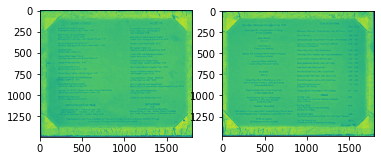

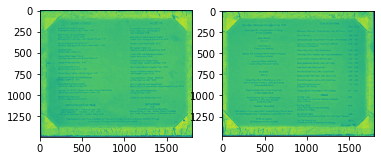

In [6]:
page1_gray = convert_to_grayscale(page1)
page2_gray = convert_to_grayscale(page2)
skimage.io.imshow_collection([page1_gray, page2_gray])

### Problem 3. Crop the images (2 points)
Since the images have quite a lot of border to them, we want to remove it in order to simplify the processing. Also, the fist page has a footer with some info about the restaurant. We don't need that so we can crop it away.

Write a function which accepts an image and a cropping box, and returns only the pixels inside the cropping box. The box is specified using its top left corner and its bottom right corner. The two corners are given as tuples of coordinates. For example, `top_left = (500, 200), bottom_right = (700, 300)` will create a cropping box with corners: `top_left = (500, 200), top_right = (500, 300), bottom_left = (700, 200), bottom_right = (700, 300)`. The resulting image will have dimensions 200x100 px. Assume that all parameters will be correct, don't perform error handling.

Be careful because the coordinates are confusing. To check you work, the function calls should contain only the text, without the border and footer of the images.

Crop the images however you like. I find the sizes specified in the function call really convenient. Feel free to change them.

**Note:** The left column in second page of the menu contains a dinner menu. It's a combination menu and it's not in our desired format. We're interested in prices of individual dishes, not dinners. In this case, it's easiest just to skip it.

We might also say we're not interested in drinks and skip the entire second image in the menu but this one will allow us to create two datasets - one for food and one for wines.

**Note 2:** It's evident that we need a little bit of rotation as well but the OCR will take care of that automatically. We don't have to do it.

In [7]:
def crop_image(image, top_left, bottom_right):
    """
    Crops a grayscale image to the specified box. top_left and bottom_right are tuples
    of two elements. The first element in each tuple specifies the x coordinate, 
    and the second element specifies the y coordinate.
    """
    x, y = top_left
    x1, y1 = bottom_right
    crop_image = image[y:y1, x:x1]
    return crop_image

In [8]:
page1_cropped = crop_image(page1_gray, (206, 124), (1700, 1245))
page2_cropped = crop_image(page2_gray, (873, 138), (1622, 1343))

In [9]:
def show_images(images):
    for image in images:
        plt.figure(figsize = (10, 8))
        plt.imshow(image, cmap = "gray")
        plt.show()

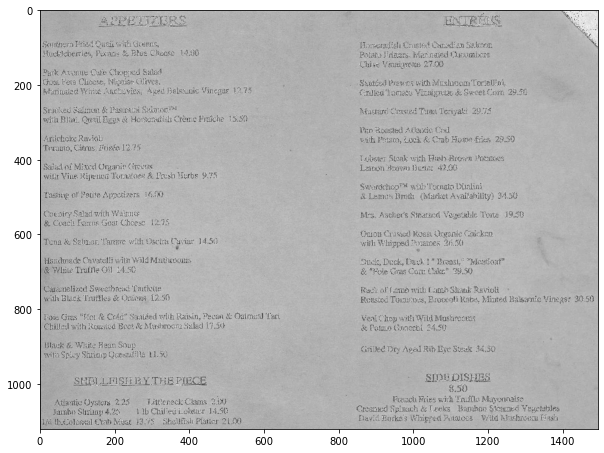

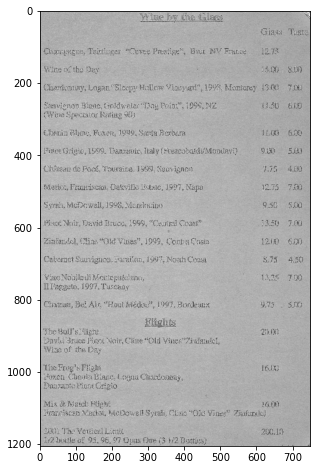

In [10]:
show_images([page1_cropped, page2_cropped])


### Problem 4. Split the first image (0 points)
The first image contains two columns of text. Our OCR application will recognize that but it will be better to split the two columns and treat them as two different images, each with a single block of text.

We can reuse our cropping function to do exactly that. Feel free to change the cropping boxes however you like.

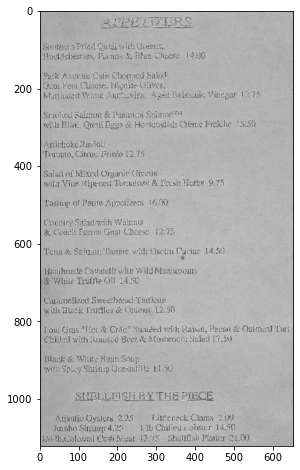

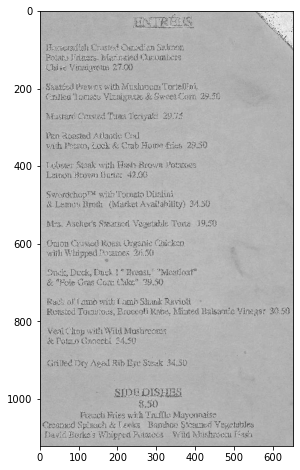

In [11]:
page1_left_cropped = crop_image(page1_gray, (206, 124), (860, 1245))
page1_right_cropped = crop_image(page1_gray, (1047, 124), (1700, 1245))
show_images([page1_left_cropped, page1_right_cropped])

### Problem 5. Concatenate the three images into one (1 point)
In order to make text processing easier, it's better to have one image, not three. Concatenate all images vertically. You should get a long, narrow image. You'll need to resize them at the beginning, before concatenating.

In [12]:
def resize_images(images):
    """
    Resizes all images to have the same width
    """
    max_width = max([image.shape[1] for image in images])
    padded_images = [np.pad(image, ((0, 0), (0, max_width - image.shape[1])), mode = "constant", constant_values = 255) for image in images]
    return padded_images

def concatenate_images(images):
    return np.concatenate(resize_images(images))

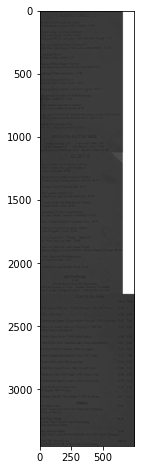

In [13]:
combined_image = concatenate_images([page1_left_cropped, page1_right_cropped, page2_cropped])
show_images([combined_image])
assert_true(combined_image.shape[0] >  combined_image.shape[1]) # Long, narrow image

# Check dimensions
assert_equal(combined_image.shape[0], page1_left_cropped.shape[0] + page1_right_cropped.shape[0] + page2_cropped.shape[0])
assert_equal(combined_image.shape[1], max(page1_left_cropped.shape[1], page1_right_cropped.shape[1], page2_cropped.shape[1]))

### Problem 6. Threshold the image (1 point)
Apply thresholding to the image to remove the background and increase contrast. Wite a function that accepts an image and two thresholds: `low` and `high` (numbers in $[0; 255]$). For each pixel value $p$
* If $p \le$ `low`, replace it with 0
* If `low`$\lt p \le$ `high`, leave it as it it
* If `high`$\lt p$, replace it with 255

**Note:** The function should return a new image. It **must not** modify the original image!

Apply the function to the combined image. You can experiment with the values of `low` and `high`.

In [14]:
def threshold_image(image, low, high):
    y, x = image.shape
    for i in range(0, y):
        for p in range(0, x):
            if image[i][p] <= low:
                image[i][p] = 0
            elif image[i][p] > high:
                image[i][p] = 255
        
    return image      

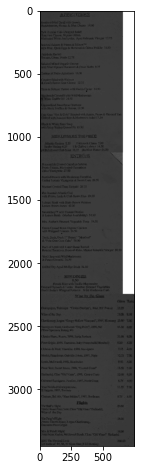

In [15]:
cleaned_image = threshold_image(combined_image, low = 50, high = 200)
show_images([cleaned_image])

Save the cleaned, thresholded and processed image.

In [16]:
if not os.path.exists("output"):
    os.makedirs("output")
skimage.io.imsave("output/menu.jpg", cleaned_image)

Now we have a nice image with high contrast. We can try applying OCR. The algorithms are an entirely different topic but we can use already working ones.

For this lab, we're going to use Google's **tesseract** library. You can install it from [here](https://github.com/UB-Mannheim/tesseract/wiki). Look for version `5.0.0`. Installation is really simple - just follow the instructions. For Windows, just follow the installer. Add the installation folder to your `PATH` environment variable.

Open a command prompt and write `tesseract -v`. If you see the version, everything has been installed correctly.

Save the final image (execute the next cell). This will save it in `output/menu.jpg` (feel free to change the destination). Open a new terminal in the `output` folder and write:

```tesseract [path to final image] [text file name]```

Example:

```tesseract menu.jpg menu```

This will create a file `menu.txt` in the `output` folder. Be patient, as the process can take 1-2 minutes on some computers.

Open the text file. Some editors (like the standard Notepad in Windows) don't recognize new lines properly. If you see a really long line, just try opening the text file in another editor, such as Notepad++.

**Note:** Tesseract is really advanced. We could have skipped the entire preprocessing but: 1) it's useful, 2) it's fun, and 3) without processing, we get more reading errors. The library likes contrasting images with little or no background.

### Problem 7. Read the text file (1 point)
Read the text file as a string. Be careful as there are some non-ASCII characters (look at "ENTRÉES" for example). Inspect it and correct any OCR errors. You can do this in any way you like. I prefer the manual way :D. I opened the output file and edited it directly.

Also, I used a little bit of regular expression magic in Notepad to make sure that all menu items are on their own lines. This is especially imporant in the "Shellfish by the piece" and "Side dishes" sections.

**Try to make the manually edited file as simple as possible to convert into tables.**

Save the text content in the variable `menu_content`.

In [17]:
menu_content = ""
# YOUR CODE HERE
raise NotImplementedError()
print(menu_content)

NotImplementedError: 

In [ ]:
assert_is_not_none(menu_content)
assert_greater(len(menu_content), 100)

The first few lines of my manually edited file are:
```
APPETIZERS
Southern Fried Quail with Greens, Huckleberries, Pecans & Blue Cheese 14.00
Park Avenue Cafe Chopped Salad Goat Feta Cheese, Niçoise Olives, Marinated
[...]
Black & White Bean Soup with Spicy Shrimp Quesadilla 11.50

SHELLFISH BY THE PIECE
Atlantic Oysters 2.25
[...]
```

Create two tables. The first should contain meals, the second - drinks. In this lab, we'll onle create the meals table. Feel free to take the problem to the end and create the other tables. The process is exactly the same. The drinks table will not be autograded.

How you create tables will depend on the way you created your text file. In my case, it was extremely simple.

### Problem 8. Create the meals table (2 points)
The table must have three columns: category (appetizers, entreés, side dishes, etc.); meal name and price. All meals are before "Wine by the Glass".

Convert all category names to lowercase.

In [ ]:
meals_string = menu_content[:menu_content.index("Wine by the Glass")]
def generate_meals_table(meals_string):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
meals_table = generate_meals_table(meals_string)
# There are 35 meals in total
# The hidden tests check for their prices and categories
assert_equal(meals_table.shape, (35, 3))

### Problem 9. Use your data (1 point)
We've come a really long way. We started with an image, we did quite a lot of data exploration, image and text processing, and conversion to tables. Now we have a `pd.DataFrame`. This is considered structured data and our job is done. After that, we can proceed as we already know.

To prove this, we'll just print some simple statistics.

Calculate the number of items (total), number of categories, total items by category, and mean price by category. Assign these to the corresponding variables that are defined.

In [ ]:
num_items_total = None
num_categories_total = None
num_items_by_category = None
mean_price_by_category = None
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert_equal(num_items_total, 35)
assert_equal(num_categories_total, 4)
assert_equal(num_items_by_category.shape, (num_categories_total,))
assert_equal(mean_price_by_category.shape, (num_categories_total,))